<a href="https://colab.research.google.com/github/TDteach/ted/blob/main/Copy_of_TED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb
!pip install pyod
!pip install torchmetrics
!pip install umap-learn
!pip install plotly

In [2]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import plotly.express as px
import torch
import torch.nn as nn
import torch.utils.data as data
import wandb

from collections import Counter, defaultdict
from pyod.models.pca import PCA
from sklearn import metrics
from sklearn.decomposition import PCA as sklearn_PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchmetrics.functional import pairwise_euclidean_distance
from umap import UMAP
from numpy.random import choice

from classifier_models import PreActResNet18, VGG
from defense_dataloader import get_dataset
from networks.models import Generator, NetC_MNIST

# Set environment variables
os.environ['WANDB_NOTEBOOK_NAME'] = 'TED.ipynb'
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Initialize argparse Namespace
opt = argparse.Namespace()
opt.dataset = "mnist"
# opt.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt.device = "cpu" # NOTE: Using CPU if GPU is not having enough memory
opt.batch_size = 100
opt.data_root = "../data/"
opt.target = 0
opt.attack_mode = "SSDT"

In [3]:
# Initialize Weights and Biases
wandb.init(project="TED", name=f"{opt.dataset}_k_{opt.target}", config=opt)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find TED.ipynb.
wandb: Currently logged in as: tdteach (iub_tdteach). Use `wandb login --relogin` to force relogin


In [4]:
# Function to load model based on dataset
def load_model():
    if opt.dataset == "mnist":
        return NetC_MNIST().to(opt.device)
    elif opt.dataset == "cifar10":
        return PreActResNet18().to(opt.device)
    elif opt.dataset == "gtsrb":
        return PreActResNet18(num_classes=43).to(opt.device)
    elif opt.dataset == "imagenet":
        return VGG('VGG16').to(opt.device)
    elif opt.dataset == "pubfig":
        return VGG('VGG16-pubfig').to(opt.device)
    else:
        raise ValueError(f"Unknown dataset: {opt.dataset}")

# Function to load model state
def load_state(model, state_dict):
    model.load_state_dict(state_dict)
    model.to(opt.device)
    model.eval()
    model.requires_grad_(False)
    return model

# Function to load the state of the model
def load_model_state():
    base_path = './checkpoints/'
    model_path = f"{base_path}{opt.dataset}/SSDT/target_{opt.target}/SSDT_{opt.dataset}_ckpt.pth.tar"
    return torch.load(model_path, map_location=opt.device)

# Set input dimensions and channels based on dataset
if opt.dataset in ["cifar10", "gtsrb"]:
    opt.input_height = 32
    opt.input_width = 32
    opt.input_channel = 3
elif opt.dataset == "mnist":
    opt.input_height = 28
    opt.input_width = 28
    opt.input_channel = 1
elif opt.dataset in ["imagenet", "pubfig"]:
    opt.input_height = 64
    opt.input_width = 64
    opt.input_channel = 3

# Set class number and defense train size
opt.class_number = {"cifar10": 10, "gtsrb": 43, "mnist": 10, "imagenet": 100, "pubfig": 83}.get(opt.dataset, 10)
opt.defense_train_size = {"cifar10": 1000, "gtsrb": 1000, "mnist": 1000, "imagenet": (opt.class_number * 100), "pubfig": (opt.class_number * 100)}.get(opt.dataset, 1000)

# Define global constant
DEFENSE_TRAIN_SIZE = opt.defense_train_size

# Load model and its state
model = load_model()
state_dict = load_model_state()
model = load_state(model, state_dict["netC"])
print(model)

# Initialize and load states for netG and netM
netG = Generator(opt)
netG = load_state(netG, state_dict["netG"])

netM = Generator(opt, out_channels=1)
netM = load_state(netM, state_dict["netM"])

NetC_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu6): ReLU(inplace=True)
  (dropout7): Dropout(p=0.1, inplace=False)
  (maxpool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear6): Linear(in_features=1024, out_features=512, bias=True)
  (relu7): ReLU(inplace=True)
  (dropout8): Dropout(p=0.1, inplace=False)
  (linear9): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# Set up dataset loaders
testset = get_dataset(opt, train=True)

# Indices of the whole dataset
indices = np.arange(len(testset))

# Split indices into benign_unknown_indices and defense_subset_indices
benign_unknown_indices, defense_subset_indices = train_test_split(
    indices, test_size=0.1, random_state=42)

# Create subsets for benign_unknown and defense
benign_unknown_subset = Subset(testset, benign_unknown_indices)
defense_subset = Subset(testset, defense_subset_indices)

# DataLoader for benign_unknown_subset
benign_unknown_loader = data.DataLoader(
    benign_unknown_subset,
    batch_size=opt.batch_size,
    num_workers=0,
    shuffle=True)

# DataLoader for defense_subset
defense_loader = data.DataLoader(
    defense_subset,
    batch_size=opt.batch_size,
    num_workers=0,
    shuffle=True)


In [6]:
# Create defense dataset for TED training with Defense Size
h_benign_preds = []
h_benign_ori_labels = []

# Predict labels using the model and collect predictions and original labels
with torch.no_grad():
    for inputs, labels in defense_loader:
        inputs, labels = inputs.to(opt.device), labels.to(opt.device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        h_benign_preds.extend(preds.cpu().numpy())
        h_benign_ori_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
h_benign_preds = np.array(h_benign_preds)
h_benign_ori_labels = np.array(h_benign_ori_labels)

# Create a mask for correctly predicted (benign) samples
benign_mask = h_benign_ori_labels == h_benign_preds

# Select indices of benign samples
benign_indices = defense_subset_indices[benign_mask]

# If the number of benign samples exceeds DEFENSE_TRAIN_SIZE, randomly select DEFENSE_TRAIN_SIZE samples
if len(benign_indices) > DEFENSE_TRAIN_SIZE:
    benign_indices = np.random.choice(benign_indices, DEFENSE_TRAIN_SIZE, replace=False)

# Create a new defense subset and DataLoader
defense_subset = Subset(testset, benign_indices)
defense_loader = data.DataLoader(defense_subset, batch_size=opt.batch_size, num_workers=0, shuffle=True)


In [7]:
# Constants for label types
VT_TEMP_LABEL = "VT"   # Victim with Trigger
NVT_TEMP_LABEL = "NVT" # Non-Victim but with Trigger
NoT_TEMP_LABEL = "NoT" # No Trigger

# Change the label mapping here if needed
label_mapping = {
    "VT": 101,
    "NVT": 102,
    "NoT": 103
}

# Define victim label (if needed to be changed)
VICTIM = 1

# Define sizes for unknown positive and negative samples; change here if needed
UNKNOWN_SIZE_POSITIVE = 400
UNKNOWN_SIZE_NEGATIVE = 200

# Initialize counters for the different types of samples
vt_count = nvt_count = NoT_count = 0

# Initialize lists to store samples for different types
temp_bd_inputs_set = []    # Store inputs for VT samples
temp_bd_labels_set = []    # Store labels for VT samples
temp_bd_pred_set = []      # Store predictions for VT samples

temp_cleanT_inputs_set = []  # Store inputs for NVT samples
temp_cleanT_labels_set = []  # Store labels for NVT samples
temp_cleanT_pred_set = []    # Store predictions for NVT samples

# Function to create backdoor inputs
def create_bd(netG, netM, inputs):
    patterns = netG(inputs)
    patterns = netG.normalize_pattern(patterns)
    masks_output = netM.threshold(netM(inputs))
    bd_inputs = inputs + (patterns - inputs) * masks_output
    return bd_inputs

# Function to create targets
def create_targets(targets, opt, label):
    new_targets = torch.ones_like(targets) * label
    return new_targets.to(opt.device)

# Main loop for generating VT and NVT sets
while vt_count < UNKNOWN_SIZE_POSITIVE or nvt_count < UNKNOWN_SIZE_NEGATIVE:
    for batch_idx, (inputs, labels) in enumerate(benign_unknown_loader):
        inputs, labels = inputs.to(opt.device), labels.to(opt.device)
        inputs_triggered = create_bd(netG, netM, inputs)
        preds_bd = torch.argmax(model(inputs_triggered), 1)
        victim_indices = (labels == VICTIM)
        non_victim_indices = (labels != VICTIM)

        # VT samples processing
        if vt_count < UNKNOWN_SIZE_POSITIVE:
            label_value = label_mapping[VT_TEMP_LABEL]
            targets_victim_bd = create_targets(labels, opt, label_value)
            correct_preds_indices = (preds_bd == opt.target)
            final_indices = victim_indices & correct_preds_indices
            temp_bd_inputs_set.append(inputs_triggered[final_indices])
            temp_bd_labels_set.append(targets_victim_bd[final_indices].to('cpu'))
            temp_bd_pred_set.append(preds_bd[final_indices].to('cpu'))
            vt_count += final_indices.sum().item()

        # NVT samples processing
        if nvt_count < UNKNOWN_SIZE_NEGATIVE:
            label_value = label_mapping[NVT_TEMP_LABEL]
            targets_clean = create_targets(labels, opt, label_value)
            temp_cleanT_inputs_set.append(inputs_triggered[non_victim_indices])
            temp_cleanT_labels_set.append(targets_clean[non_victim_indices].to('cpu'))
            temp_cleanT_pred_set.append(preds_bd[non_victim_indices].to('cpu'))
            nvt_count += non_victim_indices.sum().item()

# Concatenate and trim sets to required size
bd_inputs_set = torch.cat(temp_bd_inputs_set)[:UNKNOWN_SIZE_POSITIVE]
bd_labels_set = np.hstack(temp_bd_labels_set)[:UNKNOWN_SIZE_POSITIVE]
bd_pred_set = np.hstack(temp_bd_pred_set)[:UNKNOWN_SIZE_POSITIVE]

cleanT_inputs_set = torch.cat(temp_cleanT_inputs_set)[:UNKNOWN_SIZE_NEGATIVE]
cleanT_labels_set = np.hstack(temp_cleanT_labels_set)[:UNKNOWN_SIZE_NEGATIVE]
cleanT_pred_set = np.hstack(temp_cleanT_pred_set)[:UNKNOWN_SIZE_NEGATIVE]

# Initialize lists for benign set
benign_real_labels_set = []
benign_inputs_set = []
benign_labels_set = []
benign_pred_set = []

# Process NoT samples
for batch_idx, (inputs, labels) in zip(range(len(benign_unknown_loader)), benign_unknown_loader):
    _inputs, _labels= inputs.to(opt.device), labels.to(opt.device)
    bs = _inputs.shape[0]
    NoT_count += bs
    label_value = label_mapping[NoT_TEMP_LABEL]
    targets_benign = torch.ones_like(labels) * label_value

    # NoT samples processing
    if NoT_count <= UNKNOWN_SIZE_NEGATIVE:
        benign_real_labels_set.append(_labels.to('cpu'))
        benign_inputs_set.append(_inputs.clone().detach())
        benign_labels_set.append(targets_benign.to('cpu'))
        benign_pred_set.append(torch.argmax(model(_inputs), 1).to('cpu'))
    elif NoT_count > UNKNOWN_SIZE_NEGATIVE:
        break

# Concatenate benign sets
benign_inputs_set = torch.concatenate(benign_inputs_set)
benign_labels_set = np.concatenate(benign_labels_set)
benign_pred_set = np.concatenate(benign_pred_set)

# Custom dataset class
class CustomDataset(data.Dataset):
    def __init__(self, data, labels):
        super(CustomDataset, self).__init__()
        self.images = data
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        return img, label

# Data loaders for different sets
# VT Loader
bd_set = CustomDataset(data=bd_inputs_set, labels=bd_labels_set)
bd_loader = torch.utils.data.DataLoader(bd_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("VT set size:", len(bd_loader))
del bd_inputs_set, bd_labels_set, bd_pred_set

# NVT Loader
cleanT_set = CustomDataset(data=cleanT_inputs_set, labels=cleanT_labels_set)
cleanT_loader = torch.utils.data.DataLoader(cleanT_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("NVT set size:", len(cleanT_loader))
del cleanT_inputs_set, cleanT_labels_set, cleanT_pred_set

# NoT Loader
benign_set = CustomDataset(data=benign_inputs_set, labels=benign_labels_set)
benign_loader = torch.utils.data.DataLoader(benign_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("NoT set size:", len(benign_loader))
del benign_inputs_set, benign_labels_set, benign_pred_set


VT set size: 4
NVT set size: 2
NoT set size: 2


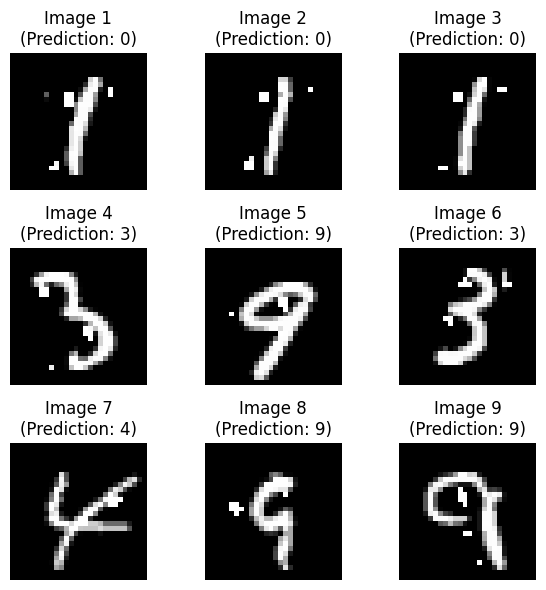

In [8]:
def display_images_grid(images, predictions, title_prefix):
    num_images = len(images)
    cols = 3  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate the required number of rows

    plt.figure(figsize=(cols * 2, rows * 2))  # Adjust figure size as needed

    for i, (img, prediction) in enumerate(zip(images, predictions)):
        plt.subplot(rows, cols, i + 1)
        img = img.squeeze().cpu().numpy()

        if img.ndim == 3:
            plt.imshow(np.transpose(img, (1, 2, 0)))  # For RGB images
        else:
            plt.imshow(img, cmap='gray')  # For grayscale images

        title = f"{title_prefix} {i+1}\n(Prediction: {prediction.item()})"
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Collect images and predictions
images_to_display = []
predictions_to_display = []

# Process samples from bd_loader and cleanT_loader
for loader, limit in [(bd_loader, 3), (cleanT_loader, 9)]:
    for inputs, labels in loader:
        inputs = inputs.to(opt.device)
        predictions = torch.argmax(model(inputs), 1).to('cpu')

        for input_image, prediction in zip(inputs, predictions):
            if len(images_to_display) < limit:
                images_to_display.append(input_image.unsqueeze(0))
                predictions_to_display.append(prediction)
            else:
                break

        if len(images_to_display) >= limit:
            break

# Display images in a compact grid layout
display_images_grid(images_to_display, predictions_to_display, title_prefix="Image")
del images_to_display, predictions_to_display


In [9]:
hook_handle = []

In [10]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Remove any existing hooks
for handle in hook_handle:
    handle.remove()

# Now, reassign the model's modules to a variable
net_children = model.modules()

Test_C = opt.class_number + 3
topological_representation = {}
candidate_ = {}


In [11]:
layer_names = {}
index = 0
for _, child in enumerate(net_children):
    if isinstance(child, nn.Conv2d) and child.kernel_size != (1, 1):
        hook_handle.append(child.register_forward_hook(get_activation("Conv2d_"+str(index))))
        index += 1

    if isinstance(child, nn.ReLU):
        hook_handle.append(child.register_forward_hook(get_activation("Relu_"+str(index))))
        index = index + 1

    if isinstance(child, nn.Linear):
        hook_handle.append(child.register_forward_hook(get_activation("Linear_"+str(index))))
        index = index + 1

    # Hook more layers here if needed

In [12]:
def fetch_activation(model, device, loader, activations):
    model.eval()
    all_h_label = []
    pred_set = []
    h_batch = {}
    activation_container = {}

    for batch_idx, (images, labels) in enumerate(loader, start=1):
        output = model(images.to(device))
        for key in activations:
            activation_container[key] = []

    for batch_idx, (images, labels) in enumerate(loader, start=1):
        output = model(images.to(device))
        pred_set.append(torch.argmax(output, -1).to(device))

        for key in activations:
            h_batch[key] = activations[key].data.view(images.shape[0], -1)
            for h in h_batch[key]:
                activation_container[key].append(h.to(device))

        for label in labels:
            all_h_label.append(label.to(device))

    for key in activation_container:
        activation_container[key] = torch.stack(activation_container[key])

    all_h_label = torch.stack(all_h_label)
    pred_set = torch.concat(pred_set)

    return all_h_label, activation_container, pred_set


In [13]:
h_bd_ori_labels, h_bd_activations, h_bd_preds = fetch_activation(model, opt.device, bd_loader, activations)
h_benign_ori_labels, h_benign_activations, h_benign_preds = fetch_activation(model, opt.device, benign_loader, activations)
h_cleanT_ori_labels, h_cleanT_activations, h_cleanT_preds = fetch_activation(model, opt.device, cleanT_loader, activations)
h_defense_ori_labels, h_defense_activations, h_defense_preds = fetch_activation(model, opt.device, defense_loader, activations)

In [14]:
def calculate_accuracy(ori_labels, preds):
    correct = torch.sum(ori_labels == preds)
    total = len(ori_labels)
    accuracy = (correct / total) * 100
    return accuracy

accuracy_defense = calculate_accuracy(h_defense_ori_labels, h_defense_preds)
accuracy_VT = calculate_accuracy(opt.target * torch.ones_like(h_bd_preds), h_bd_preds)

print(f"Accuracy on defense_loader: {accuracy_defense}%")
print(f"Accuracy on bd_loader: {accuracy_VT}%")


Accuracy on defense_loader: 99.9000015258789%
Accuracy on bd_loader: 100.0%


In [15]:
def plot_activations(activations, labels, title):
    umap_2d = UMAP(random_state=0)
    projections = umap_2d.fit_transform(activations)
    df_classes = pd.DataFrame(labels)
    fig = px.scatter(
        projections, x=0, y=1,
        color=df_classes[0].astype(str), labels={'color': 'label'}
    )
    fig.update_layout(title=title)
    fig.show()

sample_rate = 0.2  # 20%

# Assume h_bd_activations and h_defense_activations have the same keys and similar lengths
# We'll take the length of the first key as a base for sampling rate
total_bd = len(h_bd_activations[next(iter(h_bd_activations))])
total_defense = len(h_defense_activations[next(iter(h_defense_activations))])

# Generating common random indices for sampling
bd_indices = choice(total_bd, int(total_bd * sample_rate), replace=False)
defense_indices = choice(total_defense, int(total_defense * sample_rate), replace=False)

h_bd_ori_labels_prefixed = ["BD " + str(label) for label in h_bd_ori_labels]
print_umat = True

if print_umat:
    for key in h_bd_activations:
        sampled_bd = h_bd_activations[key][bd_indices]
        sampled_defense = h_defense_activations[key][defense_indices]

        # Concatenating the sampled activations
        activations_concat = np.concatenate((sampled_bd.cpu(), sampled_defense.cpu()), axis=0)

        # Concatenating the corresponding labels
        labels_concat = np.concatenate((np.array(h_bd_ori_labels_prefixed)[bd_indices], h_defense_ori_labels.cpu()[defense_indices]), axis=0)

        plot_activations(activations_concat, labels_concat, title=f"UMAP for {key}")



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [16]:

def gather_activation_into_class(target, h):
    h_c_c = [0 for _ in range(Test_C)]
    for c in range(Test_C):
        idxs = (target == c).nonzero(as_tuple=True)[0]
        if len(idxs) == 0:
            continue
        h_c = h[idxs, :]
        h_c_c[c] = h_c
    return h_c_c


def get_dis_sort(item, destinations):
    size = item.size
    item = torch.reshape(item, (1, item.shape[0]))
    new_dis = pairwise_euclidean_distance(item.to("cuda"), destinations.to("cuda"))
    _, indices_individual = torch.sort(new_dis)
    return indices_individual.to("cpu")


def getDefenseRegion(final_prediction, h_defense_activation, processing_label, layer, layer_test_region_individual):
    r_layer = h_defense_activation
    # initialize the dictionary
    if layer not in layer_test_region_individual:
        layer_test_region_individual[layer] = {}
    layer_test_region_individual[layer][processing_label] = []

    candidate_[layer] = gather_activation_into_class(final_prediction,
                                                    h_defense_activation)

    if np.ndim(candidate_[layer][processing_label]) == 0:  # Check for 0-d array
        print("No sample in this class")
    else:
        for index, item in enumerate(candidate_[layer][processing_label]):
            ranking_array = get_dis_sort(item, r_layer)[0]
            ranking_array = ranking_array[1:]
            r_ = [final_prediction[i] for i in ranking_array]
            if processing_label in r_:
                itemindex = r_.index(processing_label)
                layer_test_region_individual[layer][processing_label].append(itemindex)

    return layer_test_region_individual


def getLayerRegionDistance(new_prediction, new_activation, new_temp_label,
                           h_defense_prediction, h_defense_activation,
                           layer, layer_test_region_individual):
    r_layer = h_defense_activation
    labels = torch.unique(new_prediction)
    candidate_ = gather_activation_into_class(new_prediction, new_activation)

    if layer not in layer_test_region_individual:
        layer_test_region_individual[layer] = {}
    layer_test_region_individual[layer][new_temp_label] = []

    for processing_label in labels:
        for index, item in enumerate(candidate_[processing_label]):
            ranking_array = get_dis_sort(item, r_layer)[0]
            r_ = [h_defense_prediction[i] for i in ranking_array]
            if processing_label in r_:
                itemindex = r_.index(processing_label)
                layer_test_region_individual[layer][new_temp_label].append(itemindex)

    return layer_test_region_individual

In [17]:
class_names = np.unique(h_defense_ori_labels.cpu().numpy())

for index, label in enumerate(class_names):
        for layer in h_defense_activations:
                topological_representation = getDefenseRegion(
                        final_prediction=h_defense_preds,
                        h_defense_activation=h_defense_activations[layer],
                        processing_label=label,
                        layer=layer,
                        layer_test_region_individual=topological_representation
                )
                topo_rep_array = np.array(topological_representation[layer][label])
                print(f"Topological Representation Label [{label}] & layer [{layer}]: {topo_rep_array}")
                print(f"Mean: {np.mean(topo_rep_array)}\n")

Topological Representation Label [0] & layer [Conv2d_0]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0 10  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
Mean: 0.18518518518518517

Topological Representation Label [0] & layer [Relu_1]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0 10  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
Mean: 0.18518518518518517

Topological Representation Label [0] & layer [Conv2d_2]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [18]:
for layer_ in h_bd_activations:
        topological_representation = getLayerRegionDistance(
                new_prediction=h_bd_preds,
                new_activation=h_bd_activations[layer_],
                new_temp_label=VT_TEMP_LABEL,
                h_defense_prediction=h_defense_preds,
                h_defense_activation=h_defense_activations[layer_],
                layer=layer_,
                layer_test_region_individual=topological_representation
        )
        topo_rep_array_vt = np.array(topological_representation[layer_][VT_TEMP_LABEL])
        print(f"Topological Representation Label [{VT_TEMP_LABEL}] & layer [{layer_}]: {topo_rep_array_vt}")
        print(f"Mean: {np.mean(topo_rep_array_vt)}\n")


Topological Representation Label [VT] & layer [Conv2d_0]: [196 189 166 237 144 191 233 233 203 227 217 222 112 166 169 134  87 154
 248 134 253 184 173 244 160 237 264 204  90 229  87 232 196 265 181 240
 220 244 129 227 218 131 244 323 129 165 247 177 200 189 100 154 226 177
 280 119 217 206  87 212 202 209 285 163 231 236 176 143  83 234 221 209
 215 259 233 173 125 223 185 222 247 144 246 237 208 125 239 178 145 255
 210 214 214 114 246 172 201 183 241 271 206 170 250 228 126 193 117 306
 225 233 142 250   5 150 172 169 203 146 247 200 263 238 280 194 223 225
 133 106 157 202 169 225 188 221 180 127 226 184  77 240 160 136 250 111
 207 150 122 183 246 170 140 139 248 201 233 173 129 269 133 226 183 176
 224  65 213 230 189 166 165 224  97 133 270 168 197 205 225 196 284 221
 272 178 238 173 234 264 113 286 298 201 204 228 124 218 193 277 279 230
 256 205 228 282 219 183 214 189 211 307 198 111 221 204 143 248 134 305
 251 182  92 169 158 205 165 166 288 170 201 184 230 178 157 136 1

In [19]:
for layer_ in h_benign_activations:
        topological_representation = getLayerRegionDistance(
                new_prediction=h_benign_preds,
                new_activation=h_benign_activations[layer_],
                new_temp_label=NoT_TEMP_LABEL,
                h_defense_prediction=h_defense_preds,
                h_defense_activation=h_defense_activations[layer_],
                layer=layer_,
                layer_test_region_individual=topological_representation
        )
        topo_rep_array_not = np.array(topological_representation[layer_][NoT_TEMP_LABEL])
        print(f"Topological Representation Label [{NoT_TEMP_LABEL}] - layer [{layer_}]: {topo_rep_array_not}")
        print(f"Mean: {np.mean(topo_rep_array_not)}\n")

Topological Representation Label [NoT] - layer [Conv2d_0]: [  0   0   0   0   2   0   2   0   0   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   0
   0   0  19   0   1   0   0   0   1   0   1   0   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0   0   0   0
   1   0 179   4   0   0   0   0   0   0   0   3   0   0   0   0   0   0
   0   2   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   1   0]
Mean: 1.135

Topological Representation Label [NoT] - layer [Relu_1]: [  0   0   0   0   2   0   2   0   0   0   0   0   0   0  

In [20]:
for layer_ in h_cleanT_activations:
        topological_representation = getLayerRegionDistance(
                new_prediction=h_cleanT_preds,
                new_activation=h_cleanT_activations[layer_],
                new_temp_label=NVT_TEMP_LABEL,
                h_defense_prediction=h_defense_preds,
                h_defense_activation=h_defense_activations[layer_],
                layer=layer_,
                layer_test_region_individual=topological_representation
        )
        topo_rep_array_nvt = np.array(topological_representation[layer_][NVT_TEMP_LABEL])
        print(f"Topological Representation [{NVT_TEMP_LABEL}] - layer [{layer_}]: {topo_rep_array_nvt}")
        print(f"Mean: {np.mean(topo_rep_array_nvt)}\n")

Topological Representation [NVT] - layer [Conv2d_0]: [  0   0   0   0   0 191   0   0   0   0   0   0   0   0 260   0   0 260
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   4   0   0  14   2   0   0   1   0   1   0   0   1  26   0   0   0   0
   4   0   0   1   0   0   0   0   0  10   1   0   1   0   0   2   0   0
   0   6   0   0   0   0   0   0   0   0   0   1   0   0  69   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   5   0   1   0   1   0   1
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   5]
Mean: 4.36

Topological Representation [NVT] - layer [Relu_1]: [  0   0   0   0   0 191   0   0   0   0   0   0   0   0 260   0   0 26

In [21]:
file_name = f"{opt.dataset}_k_{opt.target}_{opt.attack_mode}.pkl"
file_path = os.path.join(file_name)

In [22]:
with open(file_path, 'wb') as file:
    pickle.dump(topological_representation, file)

wandb.save(file_path)

['/content/wandb/run-20240428_015003-dtkvvgrq/files/mnist_k_0_SSDT.pkl']

In [23]:
# Read the pickle file
with open(file_path, 'rb') as file:
    topological_representation = pickle.load(file)

In [24]:
# TED on all layers in the network

def aggregate_by_all_layers(output_label):
    inputs_container = []

    first_key = list(topological_representation.keys())[0]
    labels_container = np.repeat(output_label, len(topological_representation[first_key][output_label]))
    for l in topological_representation.keys():
        temp = []
        for j in range(len(topological_representation[l][output_label])):
            temp.append(topological_representation[l][output_label][j])
        if temp:
            inputs_container.append(np.array(temp))

    return np.array(inputs_container).T, np.array(labels_container)


inputs_all_benign = []
labels_all_benign = []

inputs_all_unknown = []
labels_all_unknown = []

first_key = list(topological_representation.keys())[0]
class_name = list(topological_representation[first_key])

for inx in class_name:

    inputs, labels = aggregate_by_all_layers(output_label=inx)

    if inx != VT_TEMP_LABEL and inx != NVT_TEMP_LABEL and inx != NoT_TEMP_LABEL:
        inputs_all_benign.append(np.array(inputs))
        labels_all_benign.append(np.array(labels))
    else:
        inputs_all_unknown.append(np.array(inputs))
        labels_all_unknown.append(np.array(labels))

inputs_all_benign = np.concatenate(inputs_all_benign)
labels_all_benign = np.concatenate(labels_all_benign)

inputs_all_unknown = np.concatenate(inputs_all_unknown)
labels_all_unknown = np.concatenate(labels_all_unknown)

pca_t = sklearn_PCA(n_components=2)
pca_fit = pca_t.fit(inputs_all_benign)

benign_trajectories = pca_fit.transform(inputs_all_benign)
trajectories = pca_fit.transform(np.concatenate((inputs_all_unknown, inputs_all_benign), axis=0))

df_classes = pd.DataFrame(np.concatenate((labels_all_unknown, labels_all_benign), axis=0))

fig_ = px.scatter(
    trajectories, x=0, y=1, color=df_classes[0].astype(str), labels={'color': 'digit'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

fig_.show()

pca = PCA(contamination=0.01, n_components='mle')
pca.fit(inputs_all_benign)

y_train_pred = pca.labels_
y_train_scores = pca.decision_scores_
y_train_scores = pca.decision_function(inputs_all_benign)
y_train_pred = pca.predict(inputs_all_benign)

y_test_scores = pca.decision_function(inputs_all_unknown)
y_test_pred = pca.predict(inputs_all_unknown)
prediction_mask = (y_test_pred == 1)
prediction_labels = labels_all_unknown[prediction_mask]
label_counts = Counter(prediction_labels)

for label, count in label_counts.items():
    print(f'Label {label}: {count}')

fpr, tpr, thresholds = metrics.roc_curve((labels_all_unknown == VT_TEMP_LABEL).astype(int), y_test_scores, pos_label=1)
print("AUC:", metrics.auc(fpr, tpr))

tn, fp, fn, tp = confusion_matrix((labels_all_unknown == VT_TEMP_LABEL).astype(int), y_test_pred).ravel()
print("TPR:", tp / (tp + fn))
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)


Label VT: 400
Label NoT: 3
Label NVT: 6
AUC: 0.9989125
TPR: 1.0
True Positives (TP): 400
False Positives (FP): 9
True Negatives (TN): 391
False Negatives (FN): 0


In [25]:
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import pandas as pd

inputs = inputs_all_unknown
labels = labels_all_unknown

inputs_flatten = inputs.flatten()
colors_ = []
index_ = []
layer_ = []

class_labels = {'VT': 'VT', 'NVT': 'NVT', 'NoT': 'NoT'}

for i, input in enumerate(inputs):
    colors_.extend([str(labels[i])] * len(input))
    index_.extend([i] * len(input))
    layer_.extend(range(len(input)))

df = pd.DataFrame(dict(
    x=layer_,
    y=inputs_flatten,
    z=colors_,
    i=index_
))

df = df.sort_values(by=['z', 'i', 'x'])

fig = go.Figure()
line_color_map = {'VT': '#EA6253', 'NoT': '#4668d8', 'NVT': '#fd9300'}

fill_color_map = {
    'VT': '#EA6253',
    'NoT': '#4668d8',
    'NVT': '#fd9300'
}

for label in ['NoT', 'NVT', 'VT']:
    data = df[df['z'] == label]
    fig.add_trace(go.Box(
        x=data['x'],
        y=data['y'],
        name=class_labels[label],
        fillcolor=fill_color_map[label],
        marker=dict(
            color=line_color_map[label],
        ),
        jitter=0.01,
        whiskerwidth=0.5,
        boxpoints='all',
        marker_size=2,
    ))

y_max = df['y'].max()

fig.update_layout(
    title="Topology Persistence Diagram",
    xaxis_title="Layer",
    yaxis_title="Nearest Rank of Same Class",
    width=1000,
    height=500,
    font=dict(
        family="Calibri",
        size=20,
        color="black"
    ),

)

fig.update_yaxes(range=[0, y_max])
save_format = "pdf"
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})


fig.update_layout(
    autosize=False,
    shapes=[
        dict(
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1,
            y1=1,
            line=dict(
                color="Black",
                width=2,
            )
        )
    ]
)

# Show all integers on x-axis
fig.update_xaxes(showticklabels=True, showgrid=False, zeroline=False, dtick=1)

fig.update_yaxes(autorange=True, showticklabels=True,
                 showgrid=False, zeroline=False)
# Hide x and y axis labels and lines
fig.update_xaxes(showticklabels=True, zeroline=False, visible=True)
fig.update_yaxes(showticklabels=True, zeroline=False, visible=True)
fig.update_layout(showlegend=True, title=None)
fig.update_layout(legend_title_text='')
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bordercolor="Black",
        borderwidth=0
    ),

    boxmode='group'  # group together boxes of the different traces for each value of x

)
save_path = f"{opt.dataset}_k_{opt.target}_{opt.attack_mode}_topology_persistence_diagram.pdf"
pio.write_image(fig, save_path, format=save_format)
wandb.save(save_path)

fig.show()

In [26]:
wandb.finish()